In [11]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import ot
from utils.image import Image as EMImage
from utils.Visualizations import *
from utils.utils import *
from aspire.noise import AnisotropicNoiseEstimator, CustomNoiseAdder, WhiteNoiseAdder
from aspire.image import Image
import itertools
import glob
import cv2

In [2]:
images_path = "/Users/erik/Personal_Projects/Thesis/DOTmark_1.0/Pictures"
category = 'MicroscopyImages'
full_path = os.path.join(os.getcwd(), images_path)
resolution = 32
image_numbers = ['01','02','03','04','05','06','07','08','09','10']
noise_values = np.logspace(start = -8, stop = 2, num = 100)
num_exp = 1000

In [3]:
len(image_numbers)

10

In [5]:
images = []
for i in range(1, len(image_numbers)+1):
    image = EMImage(resolution, category, i, images_path)
    images.append(image.image)

In [6]:
len(images)

10

In [9]:
stock_img = images[0].astype(np.float32)
# Crop to a square
n_pixels = min(stock_img.shape)
stock_img = stock_img[0:n_pixels, 0:n_pixels]
# Normalize to [0,1]
stock_img /= np.max(stock_img)

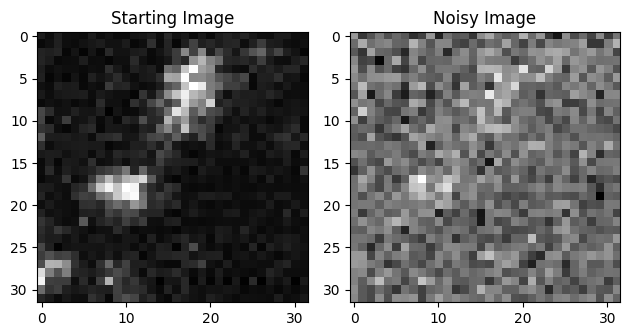

In [13]:
# Construct the Image class by passing it an array of data.
img = Image(stock_img)
# Downsample (just to speeds things up)
new_resolution = img.resolution
img = img.downsample(new_resolution)


# We will begin processing by adding some noise.
# We would like to create uniform noise for a 2d image with prescribed variance,
noise_var = np.var(img.asnumpy()) * 5

# Then create a WhiteNoiseAdder.
noise = WhiteNoiseAdder(var=noise_var, seed=123)

# We can apply the WhiteNoiseAdder to our image data.
img_with_noise = noise.forward(img)

# Extract the noise, normalize its sum to 0, and put it back on the image. 

# We will plot the original and first noisy image,
# because we only have one image in our Image stack right now.
fig, axs = plt.subplots(1, 2)
axs[0].imshow(img.asnumpy()[0], cmap=plt.cm.gray)
axs[0].set_title("Starting Image")
axs[1].imshow(img_with_noise.asnumpy()[0], cmap=plt.cm.gray)
axs[1].set_title("Noisy Image")
plt.tight_layout()
plt.show()

### Next, we would like to compare the images with their noisy counterparts. This comparisson will be done between each image and its noisy version. The comparison will include :
#### - Wasserstein distance (W_1)
#### - Wasserstein distance (W_2)
#### - L2 distance

In [16]:
def process_image(image, noise_var):
    # Construct the Image class by passing it an array of data.
    img = Image(image)
    # Then create a WhiteNoiseAdder.
    noise_array = np.random.normal(0, noise_var, img.shape)
    # We can apply the WhiteNoiseAdder to our image data.
    img_with_noise = img + noise_array
    
    # Normalize to the images original size
    img_with_noise_normalized = np.sum(img) * img_with_noise / np.sum(img_with_noise)
    
    return img_with_noise_normalized

In [67]:
# Loop through noise variances.
results = []
for noise_var in noise_values:
    W1_distances = []
    W2_distances = []
    L2_distances = []
    
    # Loop through all images for the current noise variance.
    for image in images:
        img = Image(image)  # Construct the Image class.
        
        # Generate noise and process the image.
        img_with_normalized_noise = process_image(image, noise_var)
        
        # Process images with our process and then compute distances.
        negative_noise = np.zeros(img.shape)
        negative_noise[img_with_normalized_noise<0] = img_with_normalized_noise[img_with_normalized_noise<0]
        img_with_negative_noise = img.asnumpy() - negative_noise
        # Change all negative entries of img_with_normalized_noise to 0
        img_with_normalized_noise[img_with_normalized_noise<0] = 0
        
        # Compute Wasserstein distances and L2 distance.
        cost_matrix_L1 = calculate_costs(img.size, distance_metric='L1')
        W1 = ot.emd2(img_with_negative_noise.flatten(), img_with_normalized_noise.flatten(), cost_matrix_L1)
        
        cost_matrix_L2 = calculate_costs(img.size, distance_metric='L2')
        W2 = ot.emd2(img_with_negative_noise.flatten(), img_with_normalized_noise.flatten(), cost_matrix_L2)
        
        L2 = np.linalg.norm(img.asnumpy().flatten() - img_with_normalized_noise.flatten())
        
        # Append distances to the lists for averaging.
        W1_distances.append(W1)
        W2_distances.append(W2)
        L2_distances.append(L2)
    
    # Compute averages for the current noise variance.
    results.append({
        "noise_variance": noise_var,
        "W1_distance_avg": np.mean(W1_distances),
        "W2_distance_avg": np.mean(W2_distances),
        "L2_distance_avg": np.mean(L2_distances)
    })

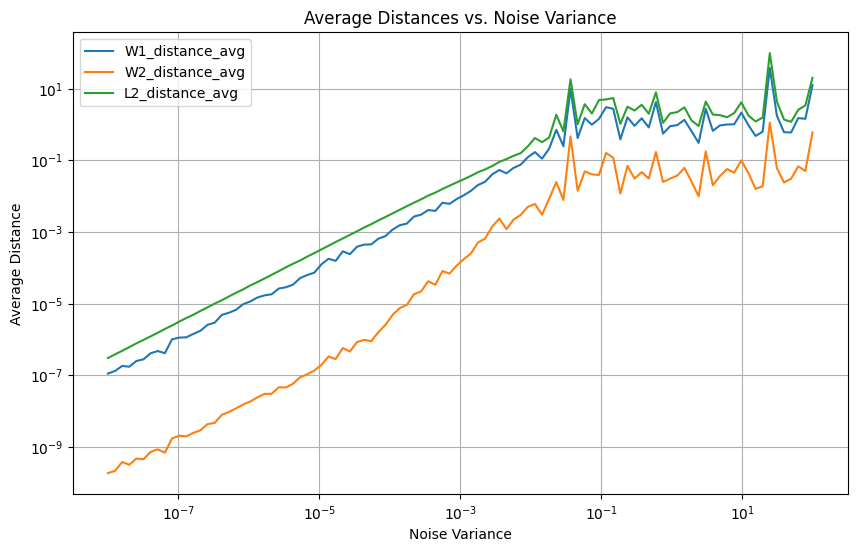

In [68]:
# Convert results to a Pandas DataFrame for easier saving and analysis.
results_df = pd.DataFrame(results)

# Save the results to a CSV file.
# results_df.to_csv("distances_vs_noise_avg.csv", index=False)

# Plotting
plt.figure(figsize=(10, 6))
for distance_metric in ["W1_distance_avg", "W2_distance_avg", "L2_distance_avg"]:
    plt.plot(results_df["noise_variance"], results_df[distance_metric], label=distance_metric)

plt.xscale("log")  # Use a log scale for the x-axis (noise variance).
plt.yscale("log")  # Use a log scale for the y-axis (average distance).
plt.xlabel("Noise Variance")
plt.ylabel("Average Distance")
plt.title("Average Distances vs. Noise Variance")
plt.legend()
plt.savefig('distances_vs_noise_avg.pdf', format='pdf', dpi=1200)
plt.grid(True)
plt.show()

In [65]:
# save the figure as a pdf
plt.savefig('distances_vs_noise_avg.pdf', format='pdf', dpi=1200)

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(10, 6))
for distance_metric in ["W1_distance_avg", "W2_distance_avg", "L2_distance_avg"]:
    plt.plot(results_df["noise_variance"], results_df[distance_metric], label=distance_metric)
    
plt.xscale("log")  # Use a log scale for the x-axis (noise variance).
plt.xlabel("Noise Variance")
plt.ylabel("Average Distance")
plt.title("Average Distances vs. Noise Variance")
plt.legend()